# Processing

scmdata has some support for processing `ScmRun` instances to calculate statistics of interest. Here we provide examples of how to use them.

At present, we can calculate:

- crossing times (e.g. 1.5C crossing times)
- exceedance probabilities
- a set of summary variables

## Load some data

For this demonstration, we are going to use MAGICC output from [RCMIP Phase 2] as available at [https://zenodo.org/record/4624566/files/data-processed-submission-database-hadcrut5-target-MAGICCv7.5.1.tar.gz?download=1](). Here we have just extracted the air temperature output for the SSPs from 1995 to 2100.

In [1]:
# NBVAL_IGNORE_OUTPUT
import numpy as np
import pandas as pd
import scmdata.processing
from scmdata import ScmRun, run_append

import matplotlib.pyplot as plt
import seaborn as sns

/Users/znicholls/Documents/AGCEC/MCastle/scmdata/src/scmdata/processing.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [2]:
# NBVAL_IGNORE_OUTPUT
magicc_output = ScmRun("magicc-rcmip-phase-2-gsat-output.csv")
magicc_output

<scmdata.ScmRun (timeseries: 4800, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     climate_model  ensemble_member        model region scenario unit  \
	0     MAGICCv7.5.1                0  unspecified  World   ssp585    K   
	1     MAGICCv7.5.1                1  unspecified  World   ssp585    K   
	2     MAGICCv7.5.1                2  unspecified  World   ssp585    K   
	3     MAGICCv7.5.1                3  unspecified  World   ssp585    K   
	4     MAGICCv7.5.1                4  unspecified  World   ssp585    K   
	...            ...              ...          ...    ...      ...  ...   
	4795  MAGICCv7.5.1              595  unspecified  World   ssp119    K   
	4796  MAGICCv7.5.1              596  unspecified  World   ssp119    K   
	4797  MAGICCv7.5.1              597  unspecified  World   ssp119    K   
	4798  MAGICCv7.5.1              598  unspecified  World   ssp119    K   
	4799  MAGICCv7.5.1              599  unspecified  World   ssp119  

## Crossing times

The first thing we do is show how to calculate the crossing times of a given threshold.

In [3]:
# NBVAL_IGNORE_OUTPUT
crossing_time_15 = scmdata.processing.calculate_crossing_times(
    magicc_output, threshold=1.5,
)
crossing_time_15

climate_model  ensemble_member  model        region  scenario  unit  variable                      
MAGICCv7.5.1   0                unspecified  World   ssp585    K     Surface Air Temperature Change    2025.0
               1                unspecified  World   ssp585    K     Surface Air Temperature Change    2029.0
               2                unspecified  World   ssp585    K     Surface Air Temperature Change    2024.0
               3                unspecified  World   ssp585    K     Surface Air Temperature Change    2023.0
               4                unspecified  World   ssp585    K     Surface Air Temperature Change    2023.0
                                                                                                        ...  
               595              unspecified  World   ssp119    K     Surface Air Temperature Change    2023.0
               596              unspecified  World   ssp119    K     Surface Air Temperature Change       NaN
               597  

The output is a `pd.Series`, which is useful for many other pieces of work.

For example, we could make a plot with e.g. seaborn.

<AxesSubplot:xlabel='1.5C crossing time', ylabel='Count'>

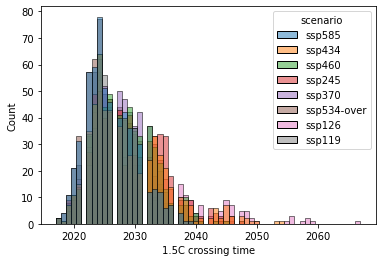

In [4]:
label = "1.5C crossing time"
pdf = crossing_time_15.reset_index().rename({0: label}, axis="columns")
sns.histplot(data=pdf, x=label, hue="scenario")

<AxesSubplot:xlabel='2.0C crossing time', ylabel='Count'>

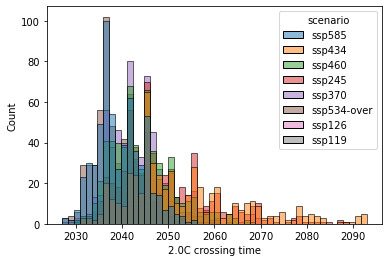

In [5]:
label = "2.0C crossing time"
crossing_time_20 = scmdata.processing.calculate_crossing_times(
    magicc_output, threshold=2.0,
)

pdf = crossing_time_20.reset_index().rename({0: label}, axis="columns")
sns.histplot(data=pdf, x=label, hue="scenario")

### Datetime output

If desired, data could be interpolated first before calculating the crossing times. In such cases, returning the output as datetime rather than year might be helpful.

In [6]:
scmdata.processing.calculate_crossing_times(
    magicc_output.resample("MS"), threshold=2.0, return_year=False,
)

climate_model  ensemble_member  model        region  scenario  unit  variable                      
MAGICCv7.5.1   0                unspecified  World   ssp585    K     Surface Air Temperature Change   2042-02-01
               1                unspecified  World   ssp585    K     Surface Air Temperature Change   2041-10-01
               2                unspecified  World   ssp585    K     Surface Air Temperature Change   2035-11-01
               3                unspecified  World   ssp585    K     Surface Air Temperature Change   2035-09-01
               4                unspecified  World   ssp585    K     Surface Air Temperature Change   2036-01-01
                                                                                                         ...    
               595              unspecified  World   ssp119    K     Surface Air Temperature Change          NaT
               596              unspecified  World   ssp119    K     Surface Air Temperature Change          

## Exceedance probabilities

Next we show how to calculate exceedance probabilities.

In [7]:
exceedance_probability_2C = scmdata.processing.calculate_exceedance_probabilities(
    magicc_output,
    process_over_cols=["ensemble_member", "variable"],
    threshold=2.0,
)
exceedance_probability_2C

climate_model  model        region  scenario     unit         
MAGICCv7.5.1   unspecified  World   ssp119       dimensionless    0.091667
                                    ssp126       dimensionless    0.350000
                                    ssp245       dimensionless    0.995000
                                    ssp370       dimensionless    1.000000
                                    ssp434       dimensionless    0.868333
                                    ssp460       dimensionless    1.000000
                                    ssp534-over  dimensionless    0.983333
                                    ssp585       dimensionless    1.000000
Name: 2.0 exceedance probability, dtype: float64


We can make a plot to compare exceedance probabilities over multiple scenarios.

,climate_model,model,region,scenario,unit,variable,Exceedance probability
0,MAGICCv7.5.1,unspecified,World,ssp119,dimensionless,2.0 exceedance probability,0.091667
1,MAGICCv7.5.1,unspecified,World,ssp126,dimensionless,2.0 exceedance probability,0.350000
2,MAGICCv7.5.1,unspecified,World,ssp245,dimensionless,2.0 exceedance probability,0.995000
3,MAGICCv7.5.1,unspecified,World,ssp370,dimensionless,2.0 exceedance probability,1.000000
4,MAGICCv7.5.1,unspecified,World,ssp434,dimensionless,2.0 exceedance probability,0.868333
5,MAGICCv7.5.1,unspecified,World,ssp460,dimensionless,2.0 exceedance probability,1.000000
6,MAGICCv7.5.1,unspecified,World,ssp534-over,dimensionless,2.0 exceedance probability,0.983333
7,MAGICCv7.5.1,unspecified,World,ssp585,dimensionless,2.0 exceedance probability,1.000000
8,MAGICCv7.5.1,unspecified,World,ssp119,dimensionless,1.5 exceedance probability,0.743333
9,MAGICCv7.5.1,unspecified,World,ssp126,dimensionless,1.5 exceedance probability,0.940000


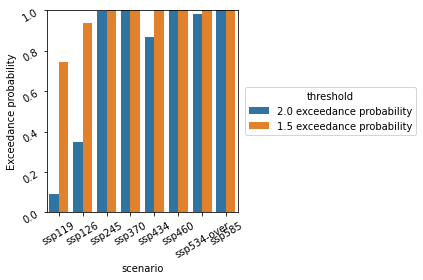

In [8]:
exceedance_probability_15C = scmdata.processing.calculate_exceedance_probabilities(
    magicc_output,
    process_over_cols=["ensemble_member", "variable"],
    threshold=1.5,
)

pdf = (
    pd.DataFrame([exceedance_probability_2C, exceedance_probability_15C,])
    .T.melt(ignore_index=False, value_name="Exceedance probability")
    .reset_index()
)
display(pdf)

ax = sns.barplot(
    data=pdf, x="scenario", y="Exceedance probability", hue="variable"
)
ax.tick_params(labelrotation=30)
ax.set_ylim([0, 1])
ax.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), title="threshold")
plt.tight_layout()

## Exceedance probabilities over time

It is also possible to calculate exceedance probabilities over time.

<AxesSubplot:xlabel='time', ylabel='dimensionless'>

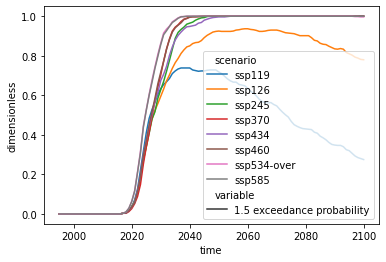

In [9]:
res = scmdata.processing.calculate_exceedance_probabilities_over_time(
    magicc_output, process_over_cols="ensemble_member", threshold=1.5,
)
res = scmdata.ScmRun(res)
res.lineplot(style="variable")

Note that taking the maximum exceedance probability over all time will be less than or equal to the exceedance probability calculated with `calculate_exceedance_probabilities` because the order of operations matters: calculating whether each ensemble member exceeds the threshold or not then seeing how many ensemble members out of the total exceed the threshold is not the same as seeing how many ensemble members exceed the threshold at each timestep and then taking the maximum over all timesteps. In general, taking the maximum value from `calculate_exceedance_probabilities_over_time` will be less than or equal to the results of `calculate_exceedance_probabilities`, as demonstrated below.

In [10]:
comparison = (
    pd.DataFrame(
        {
            "calculate_exceedance_probabilities": exceedance_probability_15C,
            "max of calculate_exceedance_probabilities_over_time": (
                res.timeseries(
                    meta=exceedance_probability_15C.index.names
                ).max(axis=1)
            ),
        }
    )
    * 100
)
comparison.round(1)

calculate_exceedance_probabilities  \
climate_model model       region scenario    unit                                                
MAGICCv7.5.1  unspecified World  ssp119      dimensionless                                74.3   
                                 ssp126      dimensionless                                94.0   
                                 ssp245      dimensionless                               100.0   
                                 ssp370      dimensionless                               100.0   
                                 ssp434      dimensionless                               100.0   
                                 ssp460      dimensionless                               100.0   
                                 ssp534-over dimensionless                               100.0   
                                 ssp585      dimensionless                               100.0   

                                                            max of calculate_exceedance_probabilities_over_time  
climate_model model       region scenario    unit                                                                
MAGICCv7.5.1  unspecified World  ssp119      dimensionless                                               73.8    
                                 ssp126      dimensionless                                               93.7    
                                 ssp245      dimensionless                                              100.0    
                                 ssp370      dimensionless                                              100.0    
                                 ssp434      dimensionless                                              100.0    
                                 ssp460      dimensionless                                              100.0    
                                 ssp534-over dimensionless                                              100.0    
                                 ssp585      dimensionless                                              100.0

## Set of summary variables

It is also possible to calculate a set of summary variables using the convenience function `calculate_summary_stats`. The documentation is given below.

In [11]:
print(scmdata.processing.calculate_summary_stats.__doc__)


    Calculate common summary statistics

    Parameters
    ----------
    scmrun : :class:`scmdata.ScmRun`
        Data of which to calculate the stats

    index : list[str]
        Columns to use in the index of the output (unit is added if not
        included)

    exceedance_probabilities_threshold : list[float]
        Thresholds to use for exceedance probabilities

    exceedance_probabilities_variable : str
        Variable to use for exceedance probability calculations

    exceedance_probabilities_naming_base : str
        String to use as the base for naming the exceedance probabilities. Each
        exceedance probability output column will have a name given by
        ``exceedance_probabilities_naming_base.format(threshold)`` where
        threshold is the exceedance probability threshold to use. If not
        supplied, the default output of
        :func:`scmdata.processing.calculate_exceedance_probabilities` will be
        used.

    progress : bool
        Should a 

It can be used to calculate summary statistics as shown below.

In [12]:
summary_stats = scmdata.processing.calculate_summary_stats(
    magicc_output,
    ["climate_model", "model", "scenario", "region"],
    exceedance_probabilities_thresholds=np.arange(1, 2.51, 0.1),
    exceedance_probabilities_variable="Surface Air Temperature Change",
    exceedance_probabilities_naming_base="Exceedance Probability|{:.2f}K",
    progress=True,
)
summary_stats

  0%|          | 0/16 [00:00<?, ?it/s]

climate_model  model        region  scenario  unit           statistic                   
MAGICCv7.5.1   unspecified  World   ssp119    dimensionless  Exceedance Probability|1.00K    1.000000
                                                             Exceedance Probability|1.10K    1.000000
                                                             Exceedance Probability|1.20K    1.000000
                                                             Exceedance Probability|1.30K    0.976667
                                                             Exceedance Probability|1.40K    0.888333
                                                                                               ...   
                                    ssp585    dimensionless  Exceedance Probability|2.10K    1.000000
                                                             Exceedance Probability|2.20K    1.000000
                                                             Exceedance Probability|2.30K    1

We can then use pandas to create summary tables of interest.

In [13]:
summary_stats.unstack(["climate_model", "statistic", "unit"])

climate_model                                  MAGICCv7.5.1  \
statistic                      Exceedance Probability|1.00K   
unit                                          dimensionless   
model       region scenario                                   
unspecified World  ssp119                               1.0   
                   ssp126                               1.0   
                   ssp245                               1.0   
                   ssp370                               1.0   
                   ssp434                               1.0   
                   ssp460                               1.0   
                   ssp534-over                          1.0   
                   ssp585                               1.0   

climate_model                                                \
statistic                      Exceedance Probability|1.10K   
unit                                          dimensionless   
model       region scenario                                   
unspecified World  ssp119                               1.0   
                   ssp126                               1.0   
                   ssp245                               1.0   
                   ssp370                               1.0   
                   ssp434                               1.0   
                   ssp460                               1.0   
                   ssp534-over                          1.0   
                   ssp585                               1.0   

climate_model                                                \
statistic                      Exceedance Probability|1.20K   
unit                                          dimensionless   
model       region scenario                                   
unspecified World  ssp119                               1.0   
                   ssp126                               1.0   
                   ssp245                               1.0   
                   ssp370                               1.0   
                   ssp434                               1.0   
                   ssp460                               1.0   
                   ssp534-over                          1.0   
                   ssp585                               1.0   

climate_model                                                \
statistic                      Exceedance Probability|1.30K   
unit                                          dimensionless   
model       region scenario                                   
unspecified World  ssp119                          0.976667   
                   ssp126                          1.000000   
                   ssp245                          1.000000   
                   ssp370                          1.000000   
                   ssp434                          1.000000   
                   ssp460                          1.000000   
                   ssp534-over                     1.000000   
                   ssp585                          1.000000   

climate_model                                                \
statistic                      Exceedance Probability|1.40K   
unit                                          dimensionless   
model       region scenario                                   
unspecified World  ssp119                          0.888333   
                   ssp126                          0.988333   
                   ssp245                          1.000000   
                   ssp370                          1.000000   
                   ssp434                          1.000000   
                   ssp460                          1.000000   
                   ssp534-over                     1.000000   
                   ssp585                          1.000000   

climate_model                                                \
statistic                      Exceedance Probability|1.50K   
unit                                          dimensionless   
model       region scenari

In [14]:
pivot_merge_unit = summary_stats.to_frame().reset_index()
pivot_merge_unit["statistic"] = (
    pivot_merge_unit["statistic"] + " (" + pivot_merge_unit["unit"] + ")"
)
pivot_merge_unit = pivot_merge_unit.drop("unit", axis="columns")
pivot_merge_unit = pivot_merge_unit.pivot_table(
    index=["climate_model", "model", "scenario", "region"],
    columns=["statistic"],
    values="value",
)
pivot_merge_unit

statistic                                     Exceedance Probability|1.00K (dimensionless)  \
climate_model model       scenario    region                                                 
MAGICCv7.5.1  unspecified ssp119      World                                            1.0   
                          ssp126      World                                            1.0   
                          ssp245      World                                            1.0   
                          ssp370      World                                            1.0   
                          ssp434      World                                            1.0   
                          ssp460      World                                            1.0   
                          ssp534-over World                                            1.0   
                          ssp585      World                                            1.0   

statistic                                     Exceedance Probability|1.10K (dimensionless)  \
climate_model model       scenario    region                                                 
MAGICCv7.5.1  unspecified ssp119      World                                            1.0   
                          ssp126      World                                            1.0   
                          ssp245      World                                            1.0   
                          ssp370      World                                            1.0   
                          ssp434      World                                            1.0   
                          ssp460      World                                            1.0   
                          ssp534-over World                                            1.0   
                          ssp585      World                                            1.0   

statistic                                     Exceedance Probability|1.20K (dimensionless)  \
climate_model model       scenario    region                                                 
MAGICCv7.5.1  unspecified ssp119      World                                            1.0   
                          ssp126      World                                            1.0   
                          ssp245      World                                            1.0   
                          ssp370      World                                            1.0   
                          ssp434      World                                            1.0   
                          ssp460      World                                            1.0   
                          ssp534-over World                                            1.0   
                          ssp585      World                                            1.0   

statistic                                     Exceedance Probability|1.30K (dimensionless)  \
climate_model model       scenario    region                                                 
MAGICCv7.5.1  unspecified ssp119      World                                       0.976667   
                          ssp126      World                                       1.000000   
                          ssp245      World                                       1.000000   
                          ssp370      World                                       1.000000   
                          ssp434      World                                       1.000000   
                          ssp460      World                                       1.000000   
                          ssp534-over World                                       1.000000   
                          ssp585      World                                       1.000000   

statistic                                     Exceedance Probability|1.40K (dimensionless)  \
climate_model model       scenario    region                                                 
MAGICCv7.5.1  unspecified ssp119      World     